In [6]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 96.1 MB/s eta 0:00:00


In [7]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.1 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import hdbscan
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import pickle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Attention, Input, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

In [9]:
users = pd.read_csv('/content/drive/MyDrive/MIPT/s_3_hackahthon/materials/raw_data/users.tsv', sep='\t')
history = pd.read_csv('/content/drive/MyDrive/MIPT/s_3_hackahthon/materials/raw_data/history.tsv', sep='\t')
validate = pd.read_csv('/content/drive/MyDrive/MIPT/s_3_hackahthon/materials/raw_data/validate.tsv', sep='\t')
validate_answers = pd.read_csv('/content/drive/MyDrive/MIPT/s_3_hackahthon/materials/raw_data/validate_answers.tsv', sep='\t')
pn_dataset = pd.read_csv('/content/drive/MyDrive/MIPT/s_3_hackahthon/materials/pn_dataset.csv')

In [10]:
pn_dataset.shape

(2299853, 11)

In [11]:
# Подготовка данных

def prepare_data(pn_dataset):
    """
    Подготовка данных для обучения.
    - Убираем колонку `hour`, так как уже есть `hour_rel`.
    - Определяем категориальные фичи.

    Возврат:
    X (фичи), y (целевая переменная), категориальные индексы.
    """
    print("[INFO] Starting data preparation...")

    # Перемешиваем данные
    pn_dataset = pn_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    print("[INFO] Data shuffled.")
    # Убираем ненужные колонки
    pn_dataset = pn_dataset.drop(columns=['hour'], errors='ignore')

    # Определяем целевую переменную и фичи
    y = pn_dataset['label']
    X = pn_dataset.drop(columns=['label', 'user_id', 'Unnamed: 0'])  # Убираем метку и идентификатор пользователя

    # Категориальные фичи
    categorical_features = ['hour_rel', 'sex', 'city_id', 'publisher']
    cat_feature_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]

    print(f"[INFO] Features shape: {X.shape}, Target shape: {y.shape}")
    print(f"[INFO] Categorical feature indices: {cat_feature_indices}")

    return X, y, cat_feature_indices

# Разделение на обучающую и тестовую выборки
def split_data(X, y):
    print("[INFO] Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"[INFO] Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
    return X_train, X_test, y_train, y_test

# Обучение CatBoost в батчах
def train_in_batches_manual(X_train, y_train, cat_features, batch_size=100000, iterations=500):
    """
    Обучение CatBoostClassifier на батчах данных вручную.

    Параметры:
    - X_train: фичи для обучения.
    - y_train: метки для обучения.
    - cat_features: индексы категориальных фичей.
    - batch_size: размер батча.
    - iterations: количество итераций на каждый батч.

    Возврат:
    Обученная модель.
    """
    print("[INFO] Starting manual batch training...")
    model = None

    for i in tqdm(range(0, len(X_train), batch_size), desc="Training batches"):
        end = i + batch_size
        batch_X = X_train.iloc[i:end]
        batch_y = y_train.iloc[i:end]
        pool = Pool(batch_X, batch_y, cat_features=cat_features)

        if model is None:
            model = CatBoostClassifier(
                iterations=iterations,
                learning_rate=0.05,
                depth=12,
                cat_features=cat_features,
                verbose=10,
                task_type="GPU",
                random_seed=42
            )
            model.fit(pool, verbose=10)
        else:
            model.fit(pool, verbose=10, use_best_model=False)

    return model

# Оценка модели и визуализация метрик
def evaluate_model(model, X_test, y_test):
    """
    Оценка модели и вывод метрик.
    """
    print("[INFO] Evaluating the model...")
    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Метрики
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"[INFO] F1-Score: {f1}")
    print(f"[INFO] ROC-AUC: {roc_auc}")

    # ROC-кривая
    print("[INFO] Plotting ROC Curve...")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC-AUC: {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()


[INFO] Preparing the dataset...
[INFO] Starting data preparation...
[INFO] Data shuffled.
[INFO] Features shape: (2299853, 7), Target shape: (2299853,)
[INFO] Categorical feature indices: [2, 3, 5, 1]
[INFO] Splitting data into train and test sets...
[INFO] Training set size: 1839882, Test set size: 459971
[INFO] Starting manual batch training...


Training batches:   0%|          | 0/19 [00:00<?, ?it/s]

0:	learn: 0.6482607	total: 262ms	remaining: 2m 10s
10:	learn: 0.4729171	total: 2.44s	remaining: 1m 48s
20:	learn: 0.4341766	total: 4.68s	remaining: 1m 46s
30:	learn: 0.4154807	total: 6.9s	remaining: 1m 44s
40:	learn: 0.4025854	total: 8.97s	remaining: 1m 40s
50:	learn: 0.3923994	total: 11.2s	remaining: 1m 38s
60:	learn: 0.3849496	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3781677	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3713930	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3663030	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3612518	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3571623	total: 24.3s	remaining: 1m 25s
120:	learn: 0.3528520	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3494771	total: 28.7s	remaining: 1m 20s
140:	learn: 0.3456043	total: 30.9s	remaining: 1m 18s
150:	learn: 0.3418239	total: 33.1s	remaining: 1m 16s
160:	learn: 0.3381255	total: 35.3s	remaining: 1m 14s
170:	learn: 0.3346630	total: 37.6s	remaining: 1m 12s
180:	learn: 0.3305850	total: 39.8s	remaining: 1m 10s
190:	

Training batches:   5%|▌         | 1/19 [01:50<33:13, 110.77s/it]

0:	learn: 0.6515021	total: 214ms	remaining: 1m 46s
10:	learn: 0.4803913	total: 2.35s	remaining: 1m 44s
20:	learn: 0.4481748	total: 4.51s	remaining: 1m 42s
30:	learn: 0.4287005	total: 6.68s	remaining: 1m 41s
40:	learn: 0.4151939	total: 8.87s	remaining: 1m 39s
50:	learn: 0.4051696	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3978299	total: 13.2s	remaining: 1m 35s
70:	learn: 0.3911858	total: 15.4s	remaining: 1m 33s
80:	learn: 0.3850188	total: 17.6s	remaining: 1m 31s
90:	learn: 0.3801108	total: 19.8s	remaining: 1m 28s
100:	learn: 0.3755050	total: 22s	remaining: 1m 26s
110:	learn: 0.3714875	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3663718	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3629411	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3590291	total: 30.8s	remaining: 1m 18s
150:	learn: 0.3559272	total: 33s	remaining: 1m 16s
160:	learn: 0.3521884	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3480813	total: 37.2s	remaining: 1m 11s
180:	learn: 0.3449898	total: 39.3s	remaining: 1m 9s
190:	lear

Training batches:  11%|█         | 2/19 [03:41<31:23, 110.79s/it]

0:	learn: 0.6475443	total: 212ms	remaining: 1m 45s
10:	learn: 0.4785902	total: 2.35s	remaining: 1m 44s
20:	learn: 0.4423302	total: 4.51s	remaining: 1m 42s
30:	learn: 0.4253961	total: 6.68s	remaining: 1m 41s
40:	learn: 0.4107716	total: 8.87s	remaining: 1m 39s
50:	learn: 0.4007875	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3927320	total: 13.2s	remaining: 1m 35s
70:	learn: 0.3861889	total: 15.4s	remaining: 1m 33s
80:	learn: 0.3804680	total: 17.6s	remaining: 1m 31s
90:	learn: 0.3751045	total: 19.8s	remaining: 1m 28s
100:	learn: 0.3701865	total: 22s	remaining: 1m 26s
110:	learn: 0.3659229	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3619785	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3586395	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3552838	total: 30.7s	remaining: 1m 18s
150:	learn: 0.3513961	total: 32.9s	remaining: 1m 16s
160:	learn: 0.3474168	total: 35.1s	remaining: 1m 14s
170:	learn: 0.3441532	total: 37.3s	remaining: 1m 11s
180:	learn: 0.3412271	total: 39.5s	remaining: 1m 9s
190:	le

Training batches:  16%|█▌        | 3/19 [05:32<29:34, 110.89s/it]

0:	learn: 0.6482537	total: 215ms	remaining: 1m 47s
10:	learn: 0.4794125	total: 2.36s	remaining: 1m 45s
20:	learn: 0.4421353	total: 4.55s	remaining: 1m 43s
30:	learn: 0.4225079	total: 6.74s	remaining: 1m 41s
40:	learn: 0.4104361	total: 8.93s	remaining: 1m 39s
50:	learn: 0.3988288	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3906856	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3835280	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3777448	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3727354	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3679480	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3632233	total: 24.3s	remaining: 1m 25s
120:	learn: 0.3596384	total: 26.6s	remaining: 1m 23s
130:	learn: 0.3562593	total: 28.7s	remaining: 1m 20s
140:	learn: 0.3524801	total: 30.9s	remaining: 1m 18s
150:	learn: 0.3481525	total: 33.1s	remaining: 1m 16s
160:	learn: 0.3449011	total: 35.3s	remaining: 1m 14s
170:	learn: 0.3407198	total: 37.5s	remaining: 1m 12s
180:	learn: 0.3380574	total: 39.7s	remaining: 1m 10s
190:

Training batches:  21%|██        | 4/19 [07:23<27:44, 110.99s/it]

0:	learn: 0.6450770	total: 213ms	remaining: 1m 46s
10:	learn: 0.4700423	total: 2.35s	remaining: 1m 44s
20:	learn: 0.4332119	total: 4.52s	remaining: 1m 43s
30:	learn: 0.4139277	total: 6.7s	remaining: 1m 41s
40:	learn: 0.4011957	total: 8.88s	remaining: 1m 39s
50:	learn: 0.3913171	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3839877	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3769547	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3718277	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3668437	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3624799	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3566111	total: 24.3s	remaining: 1m 24s
120:	learn: 0.3527252	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3494069	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3461165	total: 30.8s	remaining: 1m 18s
150:	learn: 0.3424983	total: 33s	remaining: 1m 16s
160:	learn: 0.3389532	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3357611	total: 37.4s	remaining: 1m 11s
180:	learn: 0.3322620	total: 39.6s	remaining: 1m 9s
190:	lea

Training batches:  26%|██▋       | 5/19 [09:14<25:54, 111.03s/it]

0:	learn: 0.6481807	total: 217ms	remaining: 1m 48s
10:	learn: 0.4793546	total: 2.4s	remaining: 1m 46s
20:	learn: 0.4421942	total: 4.63s	remaining: 1m 45s
30:	learn: 0.4220843	total: 6.83s	remaining: 1m 43s
40:	learn: 0.4094708	total: 9.06s	remaining: 1m 41s
50:	learn: 0.3998314	total: 11.3s	remaining: 1m 39s
60:	learn: 0.3916039	total: 13.5s	remaining: 1m 37s
70:	learn: 0.3838093	total: 15.7s	remaining: 1m 35s
80:	learn: 0.3784261	total: 17.9s	remaining: 1m 32s
90:	learn: 0.3738878	total: 20.2s	remaining: 1m 30s
100:	learn: 0.3699281	total: 22.3s	remaining: 1m 28s
110:	learn: 0.3646315	total: 24.5s	remaining: 1m 25s
120:	learn: 0.3603166	total: 26.7s	remaining: 1m 23s
130:	learn: 0.3558245	total: 28.9s	remaining: 1m 21s
140:	learn: 0.3518732	total: 31.1s	remaining: 1m 19s
150:	learn: 0.3481879	total: 33.3s	remaining: 1m 16s
160:	learn: 0.3441833	total: 35.5s	remaining: 1m 14s
170:	learn: 0.3410598	total: 37.7s	remaining: 1m 12s
180:	learn: 0.3381595	total: 39.8s	remaining: 1m 10s
190:	

Training batches:  32%|███▏      | 6/19 [11:06<24:05, 111.20s/it]

0:	learn: 0.6474829	total: 213ms	remaining: 1m 46s
10:	learn: 0.4774987	total: 2.36s	remaining: 1m 45s
20:	learn: 0.4424173	total: 4.54s	remaining: 1m 43s
30:	learn: 0.4244244	total: 6.74s	remaining: 1m 41s
40:	learn: 0.4101974	total: 8.94s	remaining: 1m 40s
50:	learn: 0.4009720	total: 11.1s	remaining: 1m 38s
60:	learn: 0.3936370	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3864687	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3800107	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3754649	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3705051	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3662302	total: 24.3s	remaining: 1m 25s
120:	learn: 0.3621032	total: 26.5s	remaining: 1m 22s
130:	learn: 0.3582594	total: 28.7s	remaining: 1m 20s
140:	learn: 0.3545339	total: 30.9s	remaining: 1m 18s
150:	learn: 0.3509694	total: 33s	remaining: 1m 16s
160:	learn: 0.3470119	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3432121	total: 37.4s	remaining: 1m 12s
180:	learn: 0.3393920	total: 39.6s	remaining: 1m 9s
190:	le

Training batches:  37%|███▋      | 7/19 [12:57<22:14, 111.19s/it]

0:	learn: 0.6461548	total: 213ms	remaining: 1m 46s
10:	learn: 0.4785034	total: 2.37s	remaining: 1m 45s
20:	learn: 0.4412135	total: 4.53s	remaining: 1m 43s
30:	learn: 0.4224938	total: 6.73s	remaining: 1m 41s
40:	learn: 0.4090286	total: 8.92s	remaining: 1m 39s
50:	learn: 0.3995125	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3909392	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3849011	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3787681	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3737180	total: 19.8s	remaining: 1m 29s
100:	learn: 0.3686154	total: 22s	remaining: 1m 27s
110:	learn: 0.3642284	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3606502	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3557818	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3514125	total: 30.8s	remaining: 1m 18s
150:	learn: 0.3472450	total: 33s	remaining: 1m 16s
160:	learn: 0.3430105	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3394234	total: 37.4s	remaining: 1m 11s
180:	learn: 0.3360423	total: 39.6s	remaining: 1m 9s
190:	lear

Training batches:  42%|████▏     | 8/19 [14:48<20:22, 111.14s/it]

0:	learn: 0.6478697	total: 215ms	remaining: 1m 47s
10:	learn: 0.4780166	total: 2.38s	remaining: 1m 45s
20:	learn: 0.4424129	total: 4.56s	remaining: 1m 43s
30:	learn: 0.4221069	total: 6.74s	remaining: 1m 42s
40:	learn: 0.4085820	total: 8.94s	remaining: 1m 40s
50:	learn: 0.3979798	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3905311	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3830114	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3771713	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3720096	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3670895	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3627448	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3586392	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3542552	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3507210	total: 30.8s	remaining: 1m 18s
150:	learn: 0.3470157	total: 33s	remaining: 1m 16s
160:	learn: 0.3437909	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3400015	total: 37.4s	remaining: 1m 11s
180:	learn: 0.3366626	total: 39.6s	remaining: 1m 9s
190:	le

Training batches:  47%|████▋     | 9/19 [16:39<18:31, 111.18s/it]

0:	learn: 0.6456616	total: 215ms	remaining: 1m 47s
10:	learn: 0.4736929	total: 2.36s	remaining: 1m 45s
20:	learn: 0.4371123	total: 4.53s	remaining: 1m 43s
30:	learn: 0.4195972	total: 6.71s	remaining: 1m 41s
40:	learn: 0.4062073	total: 8.9s	remaining: 1m 39s
50:	learn: 0.3966166	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3887440	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3817271	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3766823	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3707223	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3653753	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3606392	total: 24.3s	remaining: 1m 25s
120:	learn: 0.3564277	total: 26.5s	remaining: 1m 22s
130:	learn: 0.3520114	total: 28.7s	remaining: 1m 20s
140:	learn: 0.3481970	total: 30.9s	remaining: 1m 18s
150:	learn: 0.3443421	total: 33.1s	remaining: 1m 16s
160:	learn: 0.3406691	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3373279	total: 37.4s	remaining: 1m 12s
180:	learn: 0.3347160	total: 39.6s	remaining: 1m 9s
190:	l

Training batches:  53%|█████▎    | 10/19 [18:31<16:40, 111.21s/it]

0:	learn: 0.6482899	total: 212ms	remaining: 1m 45s
10:	learn: 0.4806187	total: 2.36s	remaining: 1m 45s
20:	learn: 0.4473567	total: 4.52s	remaining: 1m 43s
30:	learn: 0.4281045	total: 6.71s	remaining: 1m 41s
40:	learn: 0.4154743	total: 8.88s	remaining: 1m 39s
50:	learn: 0.4057244	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3983714	total: 13.2s	remaining: 1m 35s
70:	learn: 0.3913266	total: 15.4s	remaining: 1m 33s
80:	learn: 0.3860417	total: 17.6s	remaining: 1m 31s
90:	learn: 0.3796257	total: 19.8s	remaining: 1m 28s
100:	learn: 0.3758982	total: 22s	remaining: 1m 26s
110:	learn: 0.3713409	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3664566	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3619232	total: 28.5s	remaining: 1m 20s
140:	learn: 0.3580150	total: 30.7s	remaining: 1m 18s
150:	learn: 0.3545240	total: 32.9s	remaining: 1m 16s
160:	learn: 0.3510692	total: 35.1s	remaining: 1m 13s
170:	learn: 0.3476669	total: 37.3s	remaining: 1m 11s
180:	learn: 0.3447900	total: 39.5s	remaining: 1m 9s
190:	le

Training batches:  58%|█████▊    | 11/19 [20:22<14:49, 111.17s/it]

0:	learn: 0.6462762	total: 212ms	remaining: 1m 46s
10:	learn: 0.4728509	total: 2.34s	remaining: 1m 44s
20:	learn: 0.4359391	total: 4.5s	remaining: 1m 42s
30:	learn: 0.4170971	total: 6.69s	remaining: 1m 41s
40:	learn: 0.4042468	total: 8.88s	remaining: 1m 39s
50:	learn: 0.3939020	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3865892	total: 13.2s	remaining: 1m 35s
70:	learn: 0.3797464	total: 15.4s	remaining: 1m 33s
80:	learn: 0.3734886	total: 17.6s	remaining: 1m 31s
90:	learn: 0.3684298	total: 19.8s	remaining: 1m 29s
100:	learn: 0.3631618	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3588388	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3548948	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3509038	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3465832	total: 30.9s	remaining: 1m 18s
150:	learn: 0.3423201	total: 33s	remaining: 1m 16s
160:	learn: 0.3391283	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3359395	total: 37.5s	remaining: 1m 12s
180:	learn: 0.3326210	total: 39.6s	remaining: 1m 9s
190:	lea

Training batches:  63%|██████▎   | 12/19 [22:13<12:58, 111.15s/it]

0:	learn: 0.6489217	total: 213ms	remaining: 1m 46s
10:	learn: 0.4796221	total: 2.35s	remaining: 1m 44s
20:	learn: 0.4406745	total: 4.51s	remaining: 1m 42s
30:	learn: 0.4221780	total: 6.68s	remaining: 1m 41s
40:	learn: 0.4082237	total: 8.87s	remaining: 1m 39s
50:	learn: 0.3985298	total: 11s	remaining: 1m 37s
60:	learn: 0.3908302	total: 13.2s	remaining: 1m 35s
70:	learn: 0.3839748	total: 15.4s	remaining: 1m 33s
80:	learn: 0.3778884	total: 17.6s	remaining: 1m 31s
90:	learn: 0.3725368	total: 19.8s	remaining: 1m 28s
100:	learn: 0.3672869	total: 22s	remaining: 1m 26s
110:	learn: 0.3621175	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3579475	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3541442	total: 28.5s	remaining: 1m 20s
140:	learn: 0.3499311	total: 30.7s	remaining: 1m 18s
150:	learn: 0.3457993	total: 32.9s	remaining: 1m 16s
160:	learn: 0.3419822	total: 35.1s	remaining: 1m 13s
170:	learn: 0.3383934	total: 37.3s	remaining: 1m 11s
180:	learn: 0.3348706	total: 39.5s	remaining: 1m 9s
190:	lear

Training batches:  68%|██████▊   | 13/19 [24:04<11:06, 111.06s/it]

0:	learn: 0.6475031	total: 214ms	remaining: 1m 46s
10:	learn: 0.4786608	total: 2.37s	remaining: 1m 45s
20:	learn: 0.4446670	total: 4.54s	remaining: 1m 43s
30:	learn: 0.4262770	total: 6.73s	remaining: 1m 41s
40:	learn: 0.4128524	total: 8.91s	remaining: 1m 39s
50:	learn: 0.4033294	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3955395	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3888981	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3820296	total: 17.6s	remaining: 1m 31s
90:	learn: 0.3769362	total: 19.8s	remaining: 1m 29s
100:	learn: 0.3709637	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3674343	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3638682	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3601906	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3561402	total: 30.8s	remaining: 1m 18s
150:	learn: 0.3526277	total: 33s	remaining: 1m 16s
160:	learn: 0.3490825	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3451253	total: 37.4s	remaining: 1m 11s
180:	learn: 0.3414446	total: 39.6s	remaining: 1m 9s
190:	le

Training batches:  74%|███████▎  | 14/19 [25:55<09:15, 111.09s/it]

0:	learn: 0.6455388	total: 213ms	remaining: 1m 46s
10:	learn: 0.4740053	total: 2.37s	remaining: 1m 45s
20:	learn: 0.4379013	total: 4.54s	remaining: 1m 43s
30:	learn: 0.4188945	total: 6.72s	remaining: 1m 41s
40:	learn: 0.4055200	total: 8.89s	remaining: 1m 39s
50:	learn: 0.3956226	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3863191	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3797327	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3744737	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3695738	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3643163	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3593997	total: 24.3s	remaining: 1m 25s
120:	learn: 0.3547770	total: 26.3s	remaining: 1m 22s
130:	learn: 0.3509327	total: 28.5s	remaining: 1m 20s
140:	learn: 0.3471227	total: 30.7s	remaining: 1m 18s
150:	learn: 0.3441117	total: 32.9s	remaining: 1m 16s
160:	learn: 0.3403012	total: 35.1s	remaining: 1m 13s
170:	learn: 0.3367825	total: 37.3s	remaining: 1m 11s
180:	learn: 0.3332614	total: 39.5s	remaining: 1m 9s
190:	

Training batches:  79%|███████▉  | 15/19 [27:46<07:24, 111.02s/it]

0:	learn: 0.6496975	total: 215ms	remaining: 1m 47s
10:	learn: 0.4788069	total: 2.36s	remaining: 1m 45s
20:	learn: 0.4455832	total: 4.54s	remaining: 1m 43s
30:	learn: 0.4258956	total: 6.73s	remaining: 1m 41s
40:	learn: 0.4122537	total: 8.92s	remaining: 1m 39s
50:	learn: 0.4024685	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3940392	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3871410	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3824150	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3777194	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3729886	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3686012	total: 24.4s	remaining: 1m 25s
120:	learn: 0.3641738	total: 26.5s	remaining: 1m 23s
130:	learn: 0.3599635	total: 28.7s	remaining: 1m 20s
140:	learn: 0.3556665	total: 30.9s	remaining: 1m 18s
150:	learn: 0.3518295	total: 33.1s	remaining: 1m 16s
160:	learn: 0.3484984	total: 35.3s	remaining: 1m 14s
170:	learn: 0.3450937	total: 37.5s	remaining: 1m 12s
180:	learn: 0.3424164	total: 39.7s	remaining: 1m 9s
190:	

Training batches:  84%|████████▍ | 16/19 [29:37<05:33, 111.06s/it]

0:	learn: 0.6466259	total: 214ms	remaining: 1m 47s
10:	learn: 0.4749061	total: 2.36s	remaining: 1m 44s
20:	learn: 0.4392168	total: 4.54s	remaining: 1m 43s
30:	learn: 0.4213850	total: 6.71s	remaining: 1m 41s
40:	learn: 0.4078096	total: 8.91s	remaining: 1m 39s
50:	learn: 0.3986614	total: 11.1s	remaining: 1m 37s
60:	learn: 0.3916132	total: 13.3s	remaining: 1m 35s
70:	learn: 0.3851257	total: 15.5s	remaining: 1m 33s
80:	learn: 0.3783721	total: 17.7s	remaining: 1m 31s
90:	learn: 0.3728555	total: 19.9s	remaining: 1m 29s
100:	learn: 0.3687045	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3639366	total: 24.2s	remaining: 1m 24s
120:	learn: 0.3594829	total: 26.4s	remaining: 1m 22s
130:	learn: 0.3551071	total: 28.6s	remaining: 1m 20s
140:	learn: 0.3506270	total: 30.8s	remaining: 1m 18s
150:	learn: 0.3468853	total: 33s	remaining: 1m 16s
160:	learn: 0.3434600	total: 35.2s	remaining: 1m 14s
170:	learn: 0.3400047	total: 37.4s	remaining: 1m 11s
180:	learn: 0.3371019	total: 39.6s	remaining: 1m 9s
190:	le

Training batches:  89%|████████▉ | 17/19 [31:28<03:42, 111.04s/it]

0:	learn: 0.6457313	total: 215ms	remaining: 1m 47s
10:	learn: 0.4746185	total: 2.36s	remaining: 1m 45s
20:	learn: 0.4370531	total: 4.54s	remaining: 1m 43s
30:	learn: 0.4192941	total: 6.72s	remaining: 1m 41s
40:	learn: 0.4051470	total: 8.92s	remaining: 1m 39s
50:	learn: 0.3943396	total: 11.1s	remaining: 1m 38s
60:	learn: 0.3873888	total: 13.3s	remaining: 1m 36s
70:	learn: 0.3805541	total: 15.6s	remaining: 1m 34s
80:	learn: 0.3751025	total: 17.8s	remaining: 1m 31s
90:	learn: 0.3708304	total: 20s	remaining: 1m 29s
100:	learn: 0.3660923	total: 22.1s	remaining: 1m 27s
110:	learn: 0.3617879	total: 24.3s	remaining: 1m 25s
120:	learn: 0.3581073	total: 26.5s	remaining: 1m 23s
130:	learn: 0.3543156	total: 28.7s	remaining: 1m 20s
140:	learn: 0.3508285	total: 30.9s	remaining: 1m 18s
150:	learn: 0.3474001	total: 33.1s	remaining: 1m 16s
160:	learn: 0.3437679	total: 35.3s	remaining: 1m 14s
170:	learn: 0.3398010	total: 37.5s	remaining: 1m 12s
180:	learn: 0.3360604	total: 39.6s	remaining: 1m 9s
190:	le

Training batches:  95%|█████████▍| 18/19 [33:19<01:51, 111.10s/it]

0:	learn: 0.6515496	total: 121ms	remaining: 1m
10:	learn: 0.4848372	total: 14.4s	remaining: 10m 38s
20:	learn: 0.4505705	total: 28.1s	remaining: 10m 40s
30:	learn: 0.4349285	total: 39s	remaining: 9m 49s
40:	learn: 0.4242416	total: 52.8s	remaining: 9m 50s
50:	learn: 0.4157924	total: 1m 6s	remaining: 9m 41s
60:	learn: 0.4104846	total: 1m 19s	remaining: 9m 28s
70:	learn: 0.4058485	total: 1m 29s	remaining: 8m 59s
80:	learn: 0.4013835	total: 1m 41s	remaining: 8m 46s
90:	learn: 0.3982969	total: 1m 52s	remaining: 8m 25s
100:	learn: 0.3949593	total: 2m 2s	remaining: 8m 3s
110:	learn: 0.3910382	total: 2m 16s	remaining: 7m 57s
120:	learn: 0.3882792	total: 2m 30s	remaining: 7m 50s
130:	learn: 0.3865985	total: 2m 41s	remaining: 7m 34s
140:	learn: 0.3842746	total: 2m 50s	remaining: 7m 14s
150:	learn: 0.3829091	total: 3m	remaining: 6m 56s
160:	learn: 0.3808165	total: 3m 13s	remaining: 6m 46s
170:	learn: 0.3790055	total: 3m 24s	remaining: 6m 33s
180:	learn: 0.3771741	total: 3m 36s	remaining: 6m 21s
1

Training batches: 100%|██████████| 19/19 [43:46<00:00, 138.22s/it]


[INFO] Saving the trained model to 'catboost_model.pkl'...
[INFO] Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86    266439
           1       0.87      0.67      0.76    193532

    accuracy                           0.82    459971
   macro avg       0.83      0.80      0.81    459971
weighted avg       0.83      0.82      0.82    459971

[INFO] F1-Score: 0.7589652887834292
[INFO] ROC-AUC: 0.9053442728817497
[INFO] Plotting ROC Curve...


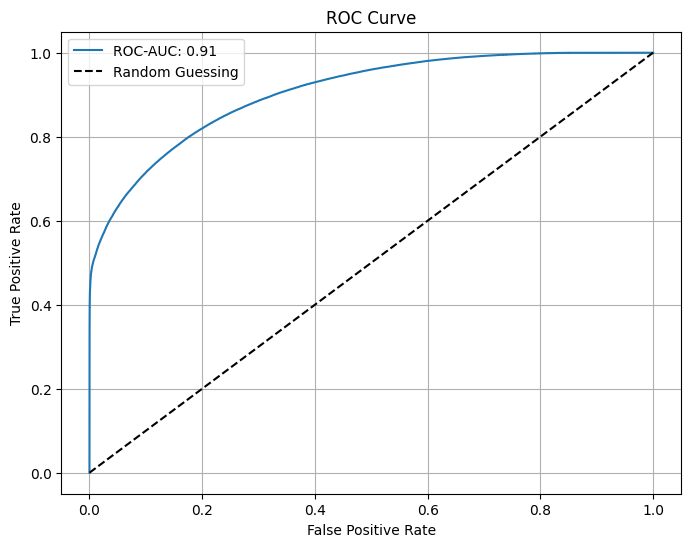

In [12]:
# Подготовка данных
print("[INFO] Preparing the dataset...")
X, y, cat_features = prepare_data(pn_dataset)
X_train, X_test, y_train, y_test = split_data(X, y)

# Обучение модели в батчах вручную
model = train_in_batches_manual(X_train, y_train, cat_features, batch_size=100000, iterations=500)

# Сохранение модели
print("[INFO] Saving the trained model to 'catboost_model.pkl'...")
with open('catboost_model_3.pkl', 'wb') as f:
    pickle.dump(model, f)

# Оценка модели
evaluate_model(model, X_test, y_test)

In [ ]:
def prepare_data_neural(pn_dataset):
    """
    Подготовка данных для обучения нейронной сети.
    - Убираем колонку `hour`, так как уже есть `hour_rel`.
    - Применяем нормализацию и one-hot encoding.

    Возврат:
    X (нормализованный и закодированный массив), y (целевая переменная).
    """
    print("[INFO] Starting data preparation...")
    # Перемешиваем данные
    pn_dataset = pn_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    # Убираем ненужные колонки
    pn_dataset = pn_dataset.drop(columns=['hour'], errors='ignore')

    # Определяем целевую переменную и фичи
    y = pn_dataset['label'].values
    X = pn_dataset.drop(columns=['label', 'user_id'])  # Убираем метку и идентификатор пользователя

    # Обработка категориальных фичей
    categorical_features = ['hour_rel', 'sex', 'city_id', 'publisher']
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_data = one_hot_encoder.fit_transform(X[categorical_features])

    # Нормализация числовых фичей
    numeric_features = ['cpm', 'age']
    scaler = StandardScaler()
    numeric_data = scaler.fit_transform(X[numeric_features])

    # Объединяем обработанные данные
    X_processed = np.hstack((numeric_data, categorical_data))

    print(f"[INFO] Features shape: {X_processed.shape}, Target shape: {y.shape}")
    return X_processed, y

# Создание модели

def build_model_neural(input_dim):
    """
    Создает глубокую нейронную сеть.

    Параметры:
    - input_dim: размер входных данных.

    Возврат:
    Модель Keras.
    """
    print("[INFO] Building the model...")

    # Входной слой
    inputs = Input(shape=(input_dim,))

    # Сеть с расширением до 2048 нейронов, затем постепенное сужение
    x = inputs
    layer_sizes = [2048, 2048, 1024, 512, 512, 512, 512, 256, 256, 256, 128, 128, 128, 64, 32, 16, 8]
    for i, size in enumerate(layer_sizes):
        x = Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

    # Выходной слой
    outputs = Dense(1, activation='sigmoid')(x)

    # Создаем модель
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())

    # Вывод количества параметров
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    print(f"[INFO] Total parameters: {total_params}, Trainable parameters: {trainable_params}")

    return model

# Оценка модели

def evaluate_model_neural(model, X_test, y_test):
    """
    Оценка модели и вывод метрик.
    """
    print("[INFO] Evaluating the model...")
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Метрики
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"[INFO] ROC-AUC: {roc_auc}")

    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC-AUC: {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Визуализация обучения

def plot_training(history):
    """
    Визуализация изменения loss и accuracy в процессе обучения.
    """
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
# Подготовка данных
print("[INFO] Preparing the dataset...")
X, y = prepare_data_neural(pn_dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


[INFO] Preparing the dataset...
[INFO] Starting data preparation...
[INFO] Features shape: (2299853, 1311), Target shape: (2299853,)


[INFO] Building the model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1311)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       2,686,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,667,873 (40.69 MB)

 Trainable params: 10,650,993 (40.63 MB)

 Non-trainable params: 16,880 (65.94 KB)

None
[INFO] Total parameters: 10667873, Trainable parameters: 10650993
Epoch 1/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.5580 - loss: 20.2920 - val_accuracy: 0.5788 - val_loss: 0.7360
Epoch 2/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5853 - loss: 0.7884 - val_accuracy: 0.6223 - val_loss: 0.7969
Epoch 3/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5950 - loss: 0.8060 - val_accuracy: 0.5784 - val_loss: 0.7885
Epoch 4/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5965 - loss: 0.8150 - val_accuracy: 0.6027 - val_loss: 0.7757
Epoch 5/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6025 - loss: 0.7895 - val_accuracy: 0.6407 - val_loss: 0.7549
Epoch 6/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6022 - loss: 0.7777 - val_accuracy: 0.6450 - val_loss: 0.7368
Epoch 7/100
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6039 - loss: 0.7660 - val_accuracy: 0.6368 - val_loss: 0.7470
Epo

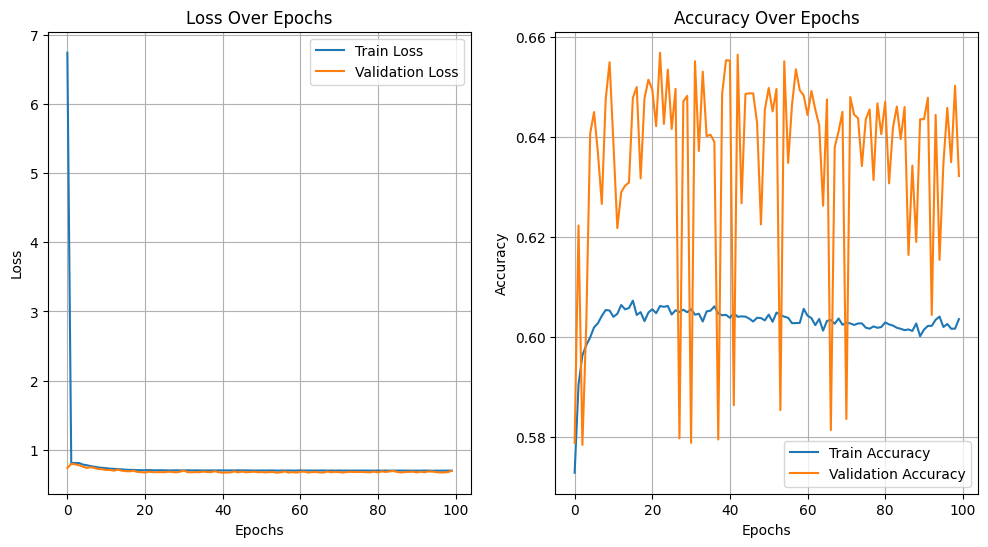

[INFO] Evaluating the model...
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.52      0.62    266439
           1       0.54      0.78      0.64    193532

    accuracy                           0.63    459971
   macro avg       0.66      0.65      0.63    459971
weighted avg       0.67      0.63      0.63    459971

[INFO] ROC-AUC: 0.7007329060694807


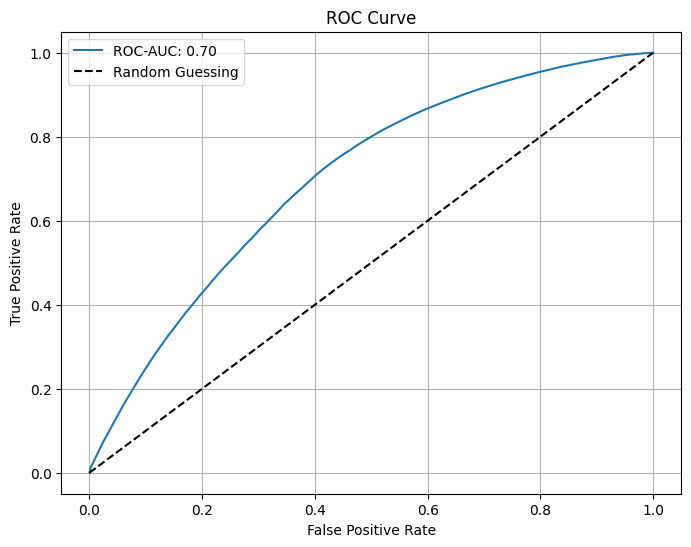

[INFO] Saving the trained model...


NameError: name 'model' is not defined

In [ ]:

# Создание и обучение модели
model_neural = build_model_neural(input_dim=X_train.shape[1])
history = model_neural.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=1024, verbose=1)

# Визуализация обучения
plot_training(history)

# Оценка модели
evaluate_model_neural(model_neural, X_test, y_test)

# Сохранение модели
print("[INFO] Saving the trained model...")
model.save('neural_network_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/MIPT/s_3_hackahthon/neural_network_model.h5')

In [ ]:
# нейросеть не дала результатов, будем использовать catboost